In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import os
from torch.utils.data import DataLoader , Dataset
from torchvision import transforms
import torchvision
from tqdm import tqdm
import codecs
import re
from PIL import Image, ImageDraw, ImageFont

In [17]:
#from google.colab import drive
#drive.mount('/content/drive')

In [18]:
#!unzip 'drive/MyDrive/imgs.zip'

In [19]:
BATCH_SIZE = 1
IMAGE_SIZE_W = 1656 # 828
IMAGE_SIZE_H = 1176
EPOCHS = 10

rand_crop_h = 792
rand_crop_w = 540

images_path = "splitted_images"
labels_path = "splitted_labels"

In [32]:
train_folders = [
     'ARMS',
     'AisazuNihaIrarenai',
     'AkkeraKanjinchou',
     'Akuhamu',
     'AosugiruHaru',
     'AppareKappore',
     'Arisa',
     'BEMADER_P',
     'BakuretsuKungFuGirl',
     'Belmondo',
     'BokuHaSitatakaKun',
     'BurariTessenTorimonocho',
     'ByebyeC-BOY',
     'Count3DeKimeteAgeru',
     'DollGun',
     'Donburakokko',
     'DualJustice',
     'EienNoWith',
     'EvaLady',
     'EverydayOsakanaChan',
     'GOOD_KISS_Ver2',
     'GakuenNoise',
     'GarakutayaManta',
     'GinNoChimera',
     'Hamlet',
     'HanzaiKousyouninMinegishiEitarou',
     'HaruichibanNoFukukoro',
     'HarukaRefrain',
     'HealingPlanet',
     "UchiNoNyan'sDiary",
     'UchuKigekiM774',
     'UltraEleven',
     'UnbalanceTokyo',
     'WarewareHaOniDearu',
     'YamatoNoHane',
     'YasasiiAkuma',
     'YouchienBoueigumi',
     'YoumaKourin',
     'YukiNoFuruMachi',
     'YumeNoKayoiji',

]

test_folders = [     
     'YumeiroCooking',
     'TotteokiNoABC',
     'ToutaMairimasu',
     'TouyouKidan',
     'TsubasaNoKioku'
]

In [33]:
class RandomCrop():
    def __init__(self, crop_size):
        self.to_tensor = transforms.ToTensor()
        self.crop_size = crop_size
    
    def augment(self, img, label):
        i, j, h, w = transforms.RandomCrop.get_params(self.to_tensor(img), self.crop_size)
        img = img[i:i+h, j:j+w]
        label = label[i:i+h, j:j+w]
        return img, label

In [183]:
class RandomText():
    def __init__(self, text_file_path, katakana_file_path, font_dir_path, font_sfx_dir_path,
                 text_x_window_range=(100, 200),
                 text_y_window_range=(100, 200),
                 word_remove_chance=0.15,
                 vertical_text_chance=0.7,
                 font_size_values=[20, 25, 30, 35, 40, 60],
                 rotate_chance=0.2,
                 rotate_range=(-60, 60),
                 sfx_chance=0.2,
                 sfx_perspective_distortion_chance=0.5):
    
    
    
        self.lorem_ipsum_jp = self.__read_text(text_file_path)
        self.katakana = list(self.__read_text(katakana_file_path))
        self.font_dir_path = font_dir_path
        self.font_sfx_dir_path = font_sfx_dir_path
        self.fonts = os.listdir(font_dir_path)
        self.fonts_sfx = os.listdir(font_sfx_dir_path)
        self.vertical_text_chance = vertical_text_chance
        self.text_x_window_range = text_x_window_range
        self.text_y_window_range = text_y_window_range
        self.word_remove_chance = word_remove_chance
        self.font_size_values = font_size_values
        self.rotate_chance = rotate_chance
        self.rotate_range = rotate_range
        self.sfx_chance = sfx_chance
        self.sfx_perspective_distortion_chance = sfx_perspective_distortion_chance
        
    def __read_text(self, file_path):
        with codecs.open(file_path, 'r', 'UTF-8') as f:
            text = f.read()
        text = text.replace('\n', '')
        text = text.replace('\r', '')
        text = re.sub(r'[a-zA-Z]', '', text)
        return text
    
    def __generate_window(self):
        window_height = np.random.randint(*self.text_x_window_range)
        window_width = np.random.randint(*self.text_y_window_range)
        
        vertical_text = np.random.rand() < self.vertical_text_chance
        
        fnt_size = np.random.choice(self.font_size_values)
        fnt_file_name = np.random.choice(self.fonts)
        
        horizontal_n_words = (window_width // fnt_size)
        vertical_n_words = (window_height // fnt_size)
        
        
        total_n_words = horizontal_n_words*vertical_n_words
        
        random_text_idx = np.random.randint(len(self.lorem_ipsum_jp) - total_n_words)
        random_text = self.lorem_ipsum_jp[random_text_idx:random_text_idx+total_n_words]
        
        new_line_range = vertical_n_words if vertical_text else horizontal_n_words
        
        random_text = list(random_text)
        for idx in range(new_line_range):
            random_text.insert((idx+1)*new_line_range, '\n')
            
        random_remove_idx = [idx for idx, word in enumerate(random_text) if np.random.rand() < self.word_remove_chance and word != r'\n']
        random_remove_idx = random_remove_idx[::-1]
        for idx in random_remove_idx:
            random_text.pop(idx)
        random_text = ''.join(random_text)
        
        window = Image.new("RGBA", (window_width, window_height), (0, 0, 0, 0))
        fnt = ImageFont.truetype(f"{self.font_dir_path}/{fnt_file_name}", fnt_size)
        
        d = ImageDraw.Draw(window)
        
        lines = random_text.split('\n')
        if not vertical_text:
            d.multiline_text((0, 0), random_text, font=fnt, fill=(0, 0, 0, 255))
        else:
            lines = random_text.split('\n')
            lines = ['\n'.join(line) for line in lines]
            lines = lines[::-1]
            for idx, line in enumerate(lines):
                d.multiline_text((idx*fnt_size, 0), line, font=fnt, fill=(0, 0, 0, 255))
        
        if np.random.rand() < self.rotate_chance:
            window = window.rotate(np.random.randint(*self.rotate_range), expand=True)
        return window
    
    def __generate_sfx(self):
        window_height = np.random.randint(*self.text_x_window_range)
        window_width = np.random.randint(*self.text_y_window_range)
        
        fnt_size = np.random.choice(self.font_size_values[4:])
        fnt_file_name = np.random.choice(self.fonts_sfx)
        
        n_words = window_width // fnt_size
        
        random_text = "".join([np.random.choice(self.katakana) for _ in range(n_words)])
        
        window = Image.new("RGBA", (window_width, window_height), (0, 0, 0, 0))
        fnt = ImageFont.truetype(f"{self.font_sfx_dir_path}/{fnt_file_name}", fnt_size)
        
        d = ImageDraw.Draw(window)
        
        d.text((0, 0), random_text, font=fnt, fill=(0, 0, 0, 255))
        
        if np.random.rand() < self.sfx_perspective_distortion_chance:
            pt_A = [0, 0]
            pt_B = [window_height, 0]
            pt_C = [window_height, window_width]
            pt_D = [0, window_width]
            
            h_offset = np.random.randint(40, 60)
            
            w_offset = np.random.randint(40, 60)
            
            pt_A_dst = [0, 0]
            pt_B_dst = [window_height + h_offset, 0]
            pt_C_dst = [window_height, window_width + w_offset]
            pt_D_dst = [0, window_width]
            
            M = cv2.getPerspectiveTransform(np.float32([pt_A, pt_B, pt_C, pt_D]),
                                            np.float32([pt_A_dst, pt_B_dst, pt_C_dst, pt_D_dst]))
            
            cv_img = np.array(np.array(window))
            
            cv_img = cv2.warpPerspective(cv_img, M, (window_width, window_height))
            
            plt.imshow(cv_img)
            plt.show()
          
            window = Image.fromarray(cv_img)
            
        window = window.rotate(np.random.randint(20, 40), expand=True)
        
        
        return window
        
    def augment(self, img, label):
        if np.random.rand() < self.sfx_chance:
            window = self.__generate_sfx()
        else:
            window = self.__generate_window()
            
        h = window.height
        w = window.width
        
        img_h = img.shape[0]
        img_w = img.shape[1]
        
        rand_x = np.random.randint(0, img_h - h - 1)
        rand_y = np.random.randint(0, img_w - w - 1)
        
        mask = np.all(label[rand_x:rand_x+h, rand_y:rand_y+w] == [0, 0, 0], axis=-1)
        
        
        label[rand_x:rand_x+h, rand_y:rand_y+w][mask] = [255, 255, 255]
        img[rand_x:rand_x+h, rand_y:rand_y+w][mask] = [255, 255, 255]
        
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img_pil = Image.fromarray(img)
        label_pil = Image.fromarray(label)
        
        label_pil.paste(window, (rand_y, rand_x), window)
        img_pil.paste(window, (rand_y, rand_x), window)
        
        label = np.array(label_pil)[:, :, ::-1] # RGB 2 BGR for support cv2 format
        img = np.array(img_pil)[:, :, ::-1]
        
        return img, label

In [184]:
random_crop = RandomCrop((rand_crop_h, rand_crop_w))
random_text = RandomText("lorem_ipsum_jp.txt", "katakana.txt", r"jp_fonts", r"jp_fonts_sfx")

In [185]:
class Manga109Dataset(Dataset):
    def __init__(self, images_path, labels_path, books, transform_colored=None, transform_gray=None, colored=False, augment=None):
        
        if colored:
            assert transform_colored is not None, "Need colored_transform"
        else:
            assert transform_gray is not None, "Need gray_transform"
        
        self.images_path = images_path
        self.labels_path = labels_path
        
        self.books = books
        
        self.colored = colored
        self.transform_gray = transform_gray
        self.transform_colored = transform_colored
        
        self.to_tensor = transforms.ToTensor()
        
        self.augment = augment
        
        self.len = 0
        
        self.index = {}
        
        for book in self.books:
            img_files = os.listdir(os.path.join(images_path, book))
            self.len += len(img_files)
            
            self.index[book] = img_files 
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        
        
        for book in self.books:
            if idx >= len(self.index[book]):
                idx -= len(self.index[book])
            else:
                try:
                    file_name = self.index[book][idx]
                    train_file_path = os.path.join(self.images_path, book, file_name)
                    label_file_path = os.path.join(self.labels_path, book, file_name)
                    break
                except:
                    raise IndexError("list index out of range")
            
        
        
        train_img = cv2.imread(train_file_path, cv2.IMREAD_COLOR)
        label_img = cv2.imread(label_file_path, cv2.IMREAD_COLOR)
        pink_pixels_mask = np.all(label_img == [255, 1, 255], axis=-1)
        
        label_img[pink_pixels_mask] = [0, 0, 0]
        
        train_img = np.pad(train_img, pad_width=((6, 0), (1, 0), (0, 0)), constant_values=255)
        label_img = np.pad(label_img, pad_width=((6, 0), (1, 0), (0, 0)), constant_values=255)
        
        if self.augment:
            train_img, label_img = self.augment.augment(train_img, label_img)
        
        label_img = cv2.cvtColor(label_img, cv2.COLOR_BGR2GRAY)
        label_img = 255 - label_img
        _, label_img = cv2.threshold(label_img, 200, 255, cv2.THRESH_BINARY)
        
        train_img = train_img / 255
        label_img = label_img / 255
        
        if self.colored:
            train_img = self.transform_colored(train_img)
        else:
            train_img = self.transform(train_img)
            
            
        label_img = self.to_tensor(label_img)
        
        return train_img.float(), label_img.float()

In [186]:

transform_colored = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = Manga109Dataset(images_path,
                          labels_path,
                          train_folders,
                          colored=True,
                          transform_colored=transform_colored)

dataset_rand_crop = Manga109Dataset(images_path,
                          labels_path,
                          train_folders,
                          colored=True,
                          transform_colored=transform_colored,
                          augment=random_crop)

dataset_rand_text = Manga109Dataset(images_path,
                          labels_path,
                          train_folders,
                          colored=True,
                          transform_colored=transform_colored,
                          augment=random_text)

dataset_test = Manga109Dataset(images_path,
                          labels_path,
                          test_folders,
                          colored=True,
                          transform_colored=transform_colored)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


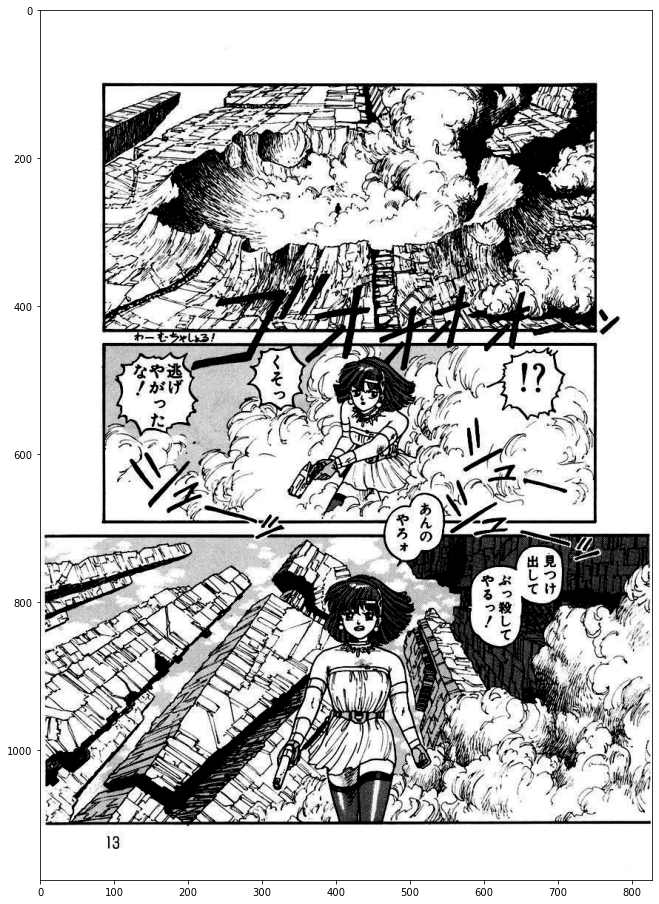

In [187]:
x, y = dataset[10]
x = np.transpose(x.numpy(), axes=(1, 2, 0))
y = np.transpose(y.numpy(), axes=(1, 2, 0))
plt.figure(figsize=(16, 16))
plt.imshow(x, vmin=0, vmax=1)

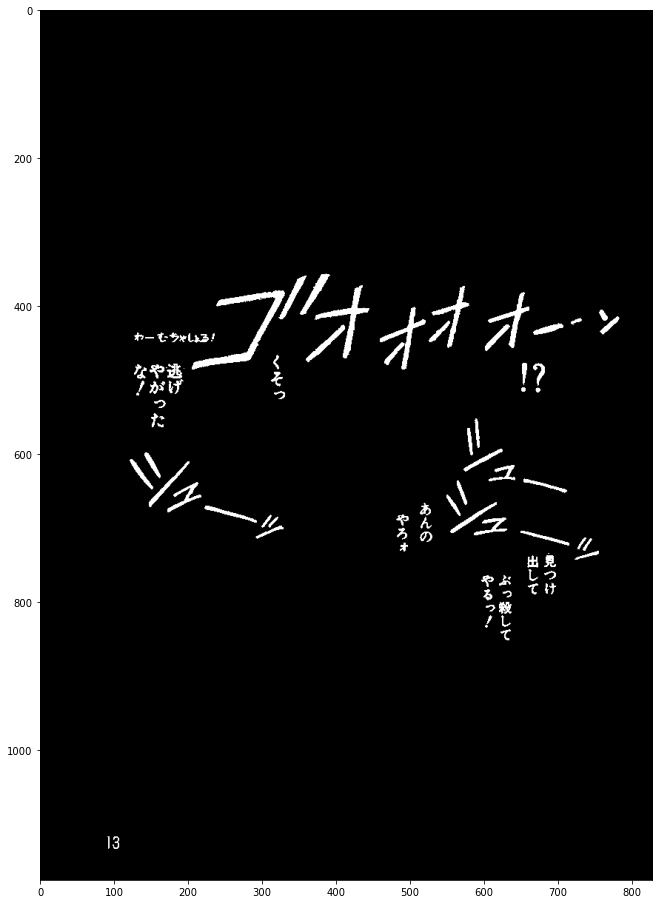

In [188]:
plt.figure(figsize=(16, 16))
plt.imshow(y[:, :, 0], vmin=0, vmax=1, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


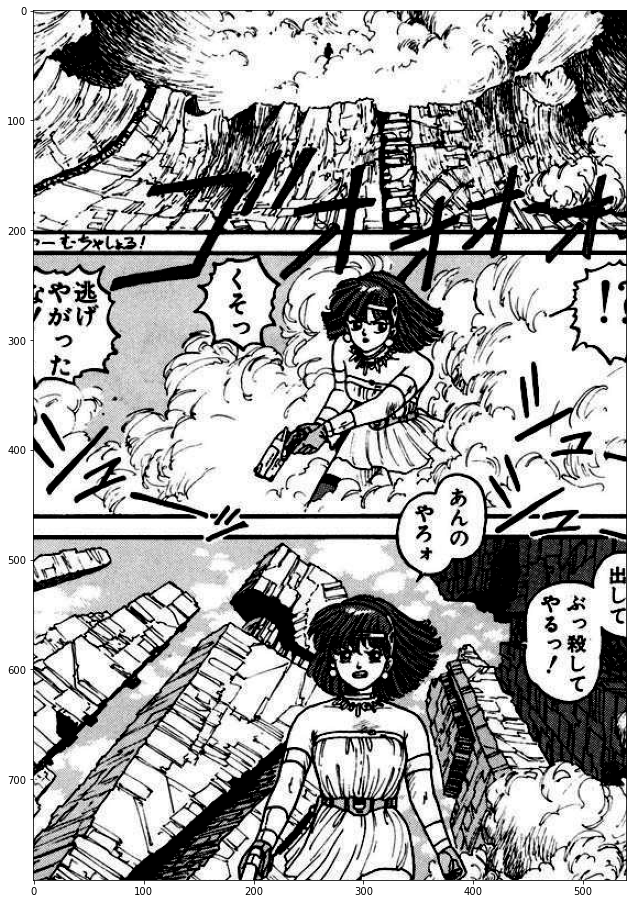

In [189]:
x, y = dataset_rand_crop[10]
x = np.transpose(x.numpy(), axes=(1, 2, 0))
y = np.transpose(y.numpy(), axes=(1, 2, 0))
plt.figure(figsize=(16, 16))
plt.imshow(x, vmin=0, vmax=1)

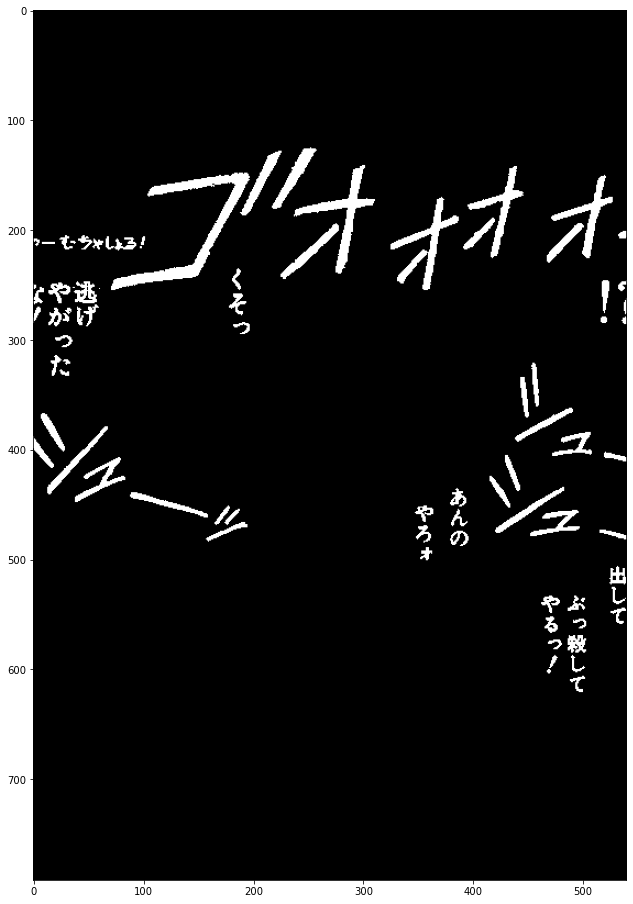

In [190]:
plt.figure(figsize=(16, 16))
plt.imshow(y[:, :, 0], vmin=0, vmax=1, cmap='gray')

[[ 0.84125622  0.          0.        ]
 [ 0.          1.22498713  0.        ]
 [-0.00304548  0.00197357  1.        ]]
ョヰ


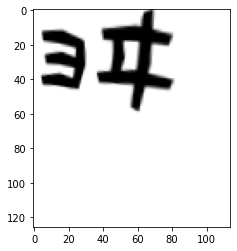

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


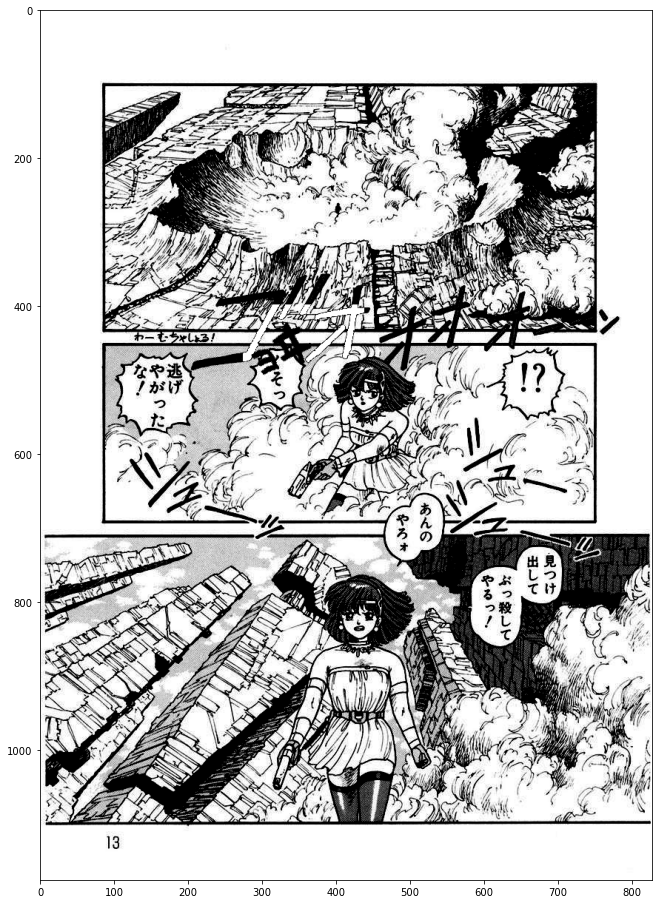

In [198]:
x, y = dataset_rand_text[10]
x = np.transpose(x.numpy(), axes=(1, 2, 0))
y = np.transpose(y.numpy(), axes=(1, 2, 0))
plt.figure(figsize=(16, 16))
plt.imshow(x, vmin=0, vmax=1)

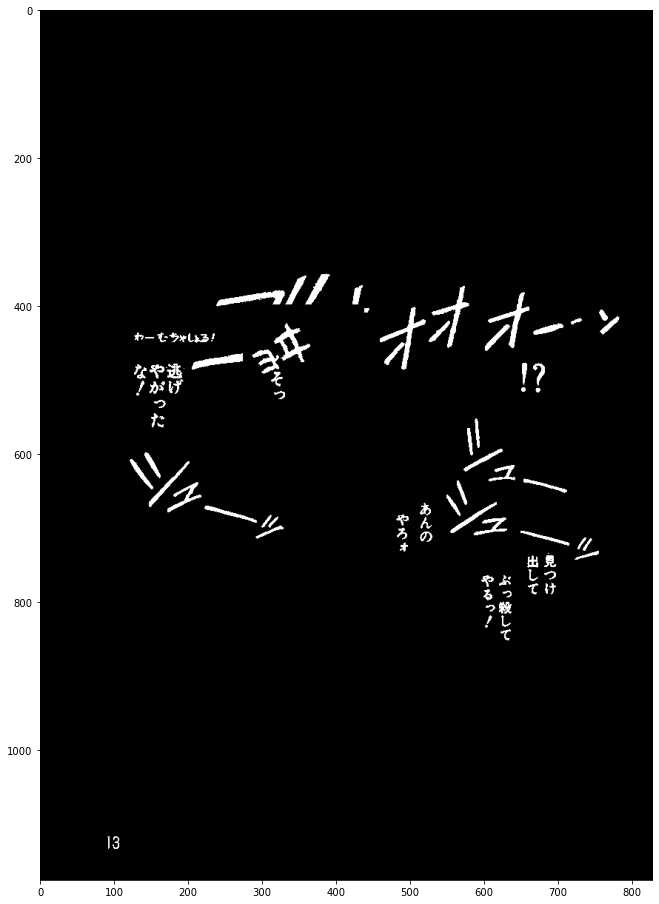

In [199]:
plt.figure(figsize=(16, 16))
plt.imshow(y[:, :, 0], vmin=0, vmax=1, cmap='gray')

In [44]:
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True)
dataloader_rand_crop = DataLoader(dataset_rand_crop, BATCH_SIZE, shuffle=True)
dataloader_rand_text = DataLoader(dataset_rand_text, BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class JapaneseTextDetector(nn.Module):
    def __convBlock(self, ch_in, ch_out, padding, kernel_size):
        conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, padding=padding, kernel_size=kernel_size),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(),
            
            nn.Conv2d(ch_out, ch_out, kernel_size=(1, 1)),
            nn.BatchNorm2d(ch_out),
            nn.ReLU()
        )
        
        return conv
    
    def __init__(self, img_h, img_w):
        super(JapaneseTextDetector, self).__init__()
        
        self.img_h = img_h
        self.img_w = img_w
        
        self.conv_block_1 = self.__convBlock(1, 16, padding=(1, 1), kernel_size=(3, 3)) 
        self.max_pool_1 = nn.MaxPool2d((2, 2)) # 1170x826 -> 585x413
        
        self.conv_block_2 = self.__convBlock(16, 32, padding=(1, 1), kernel_size=(3, 3)) 
        self.max_pool_2 = nn.MaxPool2d((2, 2)) # 585x413 -> 292x206
        
        self.conv_block_3 = self.__convBlock(32, 64, padding=(1, 1), kernel_size=(3, 3)) 
        self.max_pool_3 = nn.MaxPool2d((2, 2)) # 292x206 -> 146x103
        
        self.conv_block_4 = self.__convBlock(64, 128, padding=(1, 1), kernel_size=(3, 3)) 
        self.max_pool_4 = nn.MaxPool2d((2, 2)) # 146x103 -> 73x51
        
        self.deconv_1 = nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        
        self.conv_filter_1 = nn.Conv2d(128, 64, kernel_size=(1, 1))
        self.conv_block_5 = self.__convBlock(64, 64, padding=(1, 1), kernel_size=(3, 3)) 
        
        self.deconv_2 = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        
        self.conv_filter_2 = nn.Conv2d(64, 32, kernel_size=(1, 1))
        self.conv_block_6 = self.__convBlock(32, 32, padding=(1, 1), kernel_size=(3, 3)) 
        
        self.deconv_3 = nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 0), output_padding=(1, 0))
        
        self.conv_block_7 = nn.Conv2d(32, 1, padding=(1, 1), kernel_size=(3, 3))
        
    def forward(self, x):
        c1 = self.conv_block_1(x)
        x = self.max_pool_1(c1)
        
        c2 = self.conv_block_2(x)
        x = self.max_pool_2(c2)
        
        c3 = self.conv_block_3(x)
        x = self.max_pool_3(c3)
        
        x = self.conv_block_4(x)
        
        x = self.deconv_1(x)
        
        x = torch.cat((c3, x), 1)
        x = self.conv_filter_1(x)
        
        x = self.conv_block_5(x)
        x = self.deconv_2(x)
        
        x = torch.cat((c2, x), 1)
        x = self.conv_filter_2(x)
        
        x = self.conv_block_6(x)
        x = self.deconv_3(x)
        
        x = torch.cat((c1, x), 1)
        x = self.conv_block_7(x)

        return x

In [ ]:
class Resnet34(nn.Module):
    def __init__(self):
        super(Resnet34, self).__init__()
        
        resnet34 = torchvision.models.resnet34()
        
        self.conv1 = resnet34.conv1
        self.maxpool = resnet34.maxpool
        self.layer1 = resnet34.layer1
        self.layer2 = resnet34.layer2
        self.layer3 = resnet34.layer3
        self.layer4 = resnet34.layer4
        
        
    def forward(self, x):
        x = self.conv1(x)
        e1 = self.maxpool(x)
        e1 = self.layer1(e1)
        e2 = self.layer2(e1)
        e3 = self.layer3(e2)
        e4 = self.layer4(e3)
        
        return x, e1, e2, e3, e4

In [ ]:
class PretrainedTextDetector(nn.Module):
    def __doubleConv(self, ch_in, ch_out, padding, kernel_size):
        conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, padding=padding, kernel_size=kernel_size),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(),
            
            nn.Conv2d(ch_out, ch_out, padding=padding, kernel_size=kernel_size),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(),
        )
        
        return conv
    
    def __init__(self, img_h, img_w, finetune=False):
        super(PretrainedTextDetector, self).__init__()

        self.img_h = img_h
        self.img_w = img_w
        self.finetune = finetune
        self.resnet = Resnet34()
        self.resnet.train()
        
        
        self.conv_1 = self.__doubleConv(512, 512, (1, 1), (3, 3))
        
        self.deconv_1 = nn.ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        
        self.conv_2 = self.__doubleConv(512, 256, (1, 1), (3, 3))
        
        self.deconv_2 = nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(0, 1))
        
        self.conv_3 = self.__doubleConv(256, 128, (1, 1), (3, 3))
        
        self.deconv_3 = nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 0))
        
        self.conv_4 = self.__doubleConv(128, 64, (1, 1), (3, 3))
        
        self.deconv_4 = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        
        self.conv_5 = self.__doubleConv(96, 64, (1, 1), (3, 3))
        
        self.deconv_5 = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        
        self.conv_6 = self.__doubleConv(32, 16, (1, 1), (3, 3))
        self.out_conv = nn.Conv2d(16, 1, padding=(1, 1), kernel_size=(3, 3))
        
        for param in self.parameters():
            param.requires_grad = True

    def forward(self, x):
        
        if self.finetune:
            e0, e1, e2, e3, e4 = self.resnet(x)
        else:
            with torch.no_grad():
                e0, e1, e2, e3, e4 = self.resnet(x)
        x = self.conv_1(e4)
        
        x = self.deconv_1(x)

        x = torch.cat((x, e3), 1)
        
        x = self.conv_2(x)
        
        x = self.deconv_2(x)

        x = torch.cat((x, e2), 1)
        
        x = self.conv_3(x)
        
        x = self.deconv_3(x)
        
        x = torch.cat((x, e1), 1)
        
        x = self.conv_4(x)
        
        x = self.deconv_4(x)
        
        x = torch.cat((x, e0), 1)
        
        x = self.conv_5(x)
        
        x = self.deconv_5(x)

        x = self.conv_6(x)
        
        x = self.out_conv(x)
        return x

In [ ]:
model = PretrainedTextDetector(IMAGE_SIZE_W, IMAGE_SIZE_H, finetune=True).to(device)

In [ ]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [ ]:
from torchvision.ops.focal_loss import sigmoid_focal_loss

In [ ]:
loss_fn = lambda x,y: sigmoid_focal_loss(x, y, reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=1, threshold=1e-2)

In [ ]:
def train(epoch, model, train_loader, optimizer, device):
    
    running_loss = 0

    model.train()
    for i, data in tqdm(enumerate(train_loader)):
        images, y = data

        images, y = images.to(device), y.to(device)

        
        outputs = model(images)
        
        loss = loss_fn(outputs, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()* images.size(0)
        
    
    total_loss = running_loss / len(train_loader.dataset)
    scheduler.step(total_loss) 
    
    print(f"Epoch #{epoch} Train loss: {total_loss}")
    return total_loss

In [ ]:
def test(epoch, model, test_loader, device):

    running_loss = 0

    model.eval()
    for i, data in tqdm(enumerate(test_loader)):
        images, y = data

        images, y = images.to(device), y.to(device)

        print(images.shape)
        raise Exception()
        
        outputs = model(images)
        
        loss = loss_fn(outputs, y)
        
        running_loss += loss.item()* images.size(0)
        
    
    total_loss = running_loss / len(test_loader.dataset)
    
    print(f"Epoch #{epoch} Test loss: {total_loss}")
    return total_loss

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='model_augment_full_loss')

for epoch in range(EPOCHS):
    loss = 0
    loss += train(epoch, model, dataloader, optimizer, device)
    loss += train(epoch, model, dataloader_rand_crop, optimizer, device)
    loss += train(epoch, model, dataloader_rand_text, optimizer, device)
    loss /= 3
    writer.add_scalar('Loss/Train', loss, epoch)
    
    loss = test(epoch, model, dataloader_test, device)
    writer.add_scalar('Loss/Val', loss, epoch)
    
    torch.save(model.state_dict(), "model_last_checkpoint.pth")

800it [08:20,  1.60it/s]


Epoch #0 Train loss: 0.01261298517609248


800it [04:39,  2.86it/s]


Epoch #0 Train loss: 0.011355755547410808


800it [08:34,  1.56it/s]


Epoch #0 Train loss: 0.00918570334542892


100it [00:29,  3.39it/s]


Epoch #0 Test loss: 0.00760140529833734


800it [08:15,  1.62it/s]


Epoch #1 Train loss: 0.008871968905004905


800it [04:44,  2.82it/s]


Epoch #1 Train loss: 0.009755194475292227


800it [08:51,  1.51it/s]


Epoch #1 Train loss: 0.008401375664252555


3it [00:02,  1.27it/s]


RuntimeError: CUDA out of memory. Tried to allocate 60.00 MiB (GPU 0; 4.00 GiB total capacity; 3.21 GiB already allocated; 0 bytes free; 3.45 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
torch.save(model.state_dict(), "model_augment_all_no_pretrained.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predict')

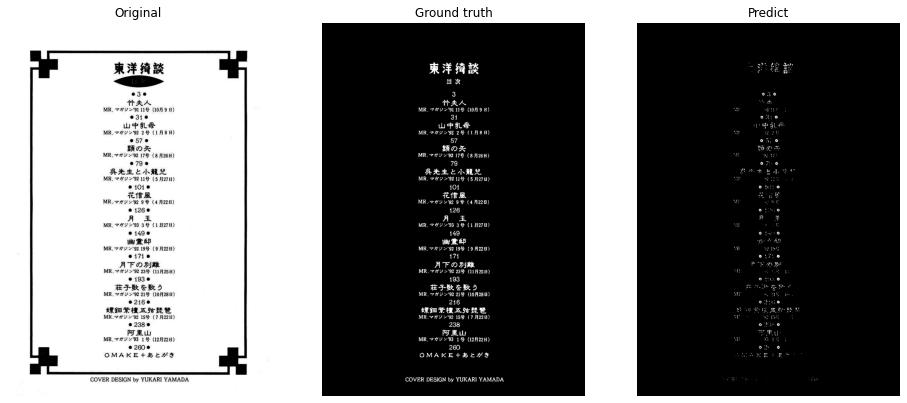

In [ ]:
x, y = next(iter(dataloader_test))

model.cpu()
out = torch.sigmoid(model(x))

out = out.cpu().detach().numpy()
out = out[0]

y = np.transpose(y[0], (1, 2, 0))
x = np.transpose(x[0], (1, 2, 0))
out = np.transpose(out, (1, 2, 0))

_, out = cv2.threshold(out, 0.5, 1, cv2.THRESH_BINARY)

fig = plt.figure(figsize=(16, 9))
fig.add_subplot(1, 3, 1)

plt.imshow(x, cmap='gray')
plt.axis('off')
plt.title("Original")

fig.add_subplot(1, 3, 2)

plt.imshow(y[:, :, 0], cmap='gray')
plt.axis('off')
plt.title("Ground truth")

fig.add_subplot(1, 3, 3)

plt.imshow(out, cmap='gray')
plt.axis('off')
plt.title("Predict")

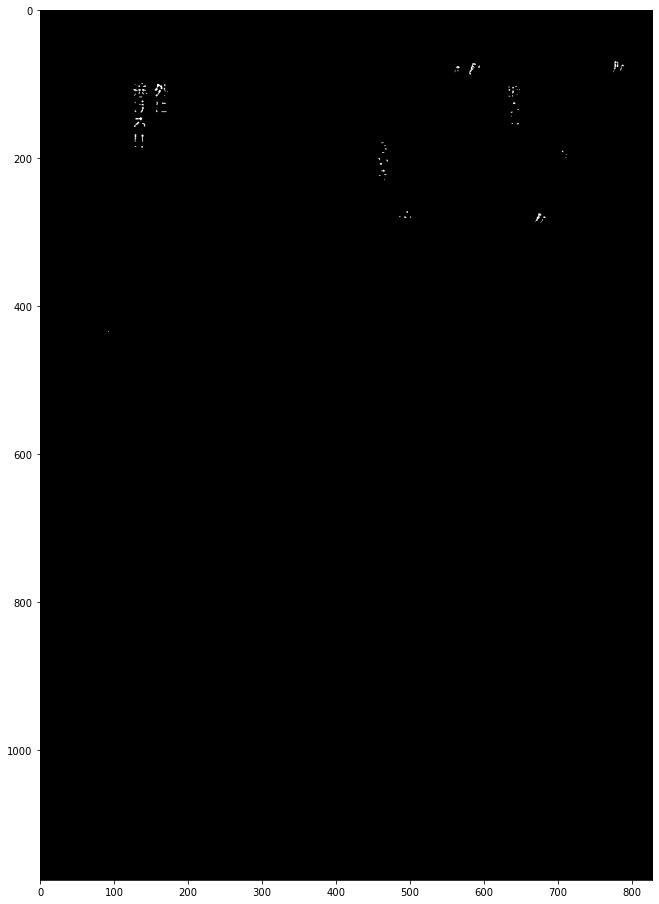

In [ ]:
plt.figure(figsize=(16, 16))
plt.imshow(out, cmap='gray')

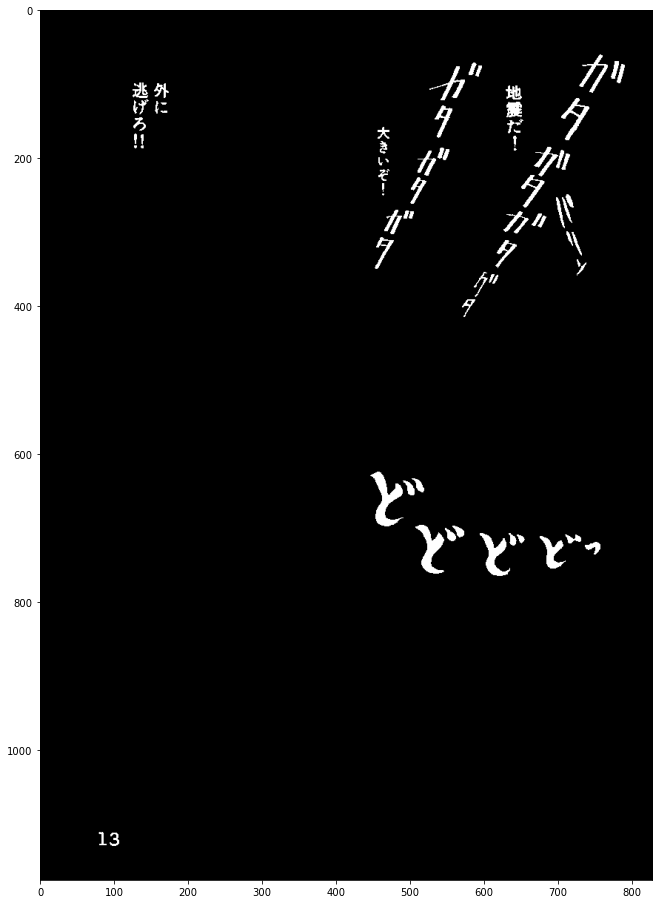

In [ ]:
plt.figure(figsize=(16, 16))
plt.imshow(y[:, :, 0], cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


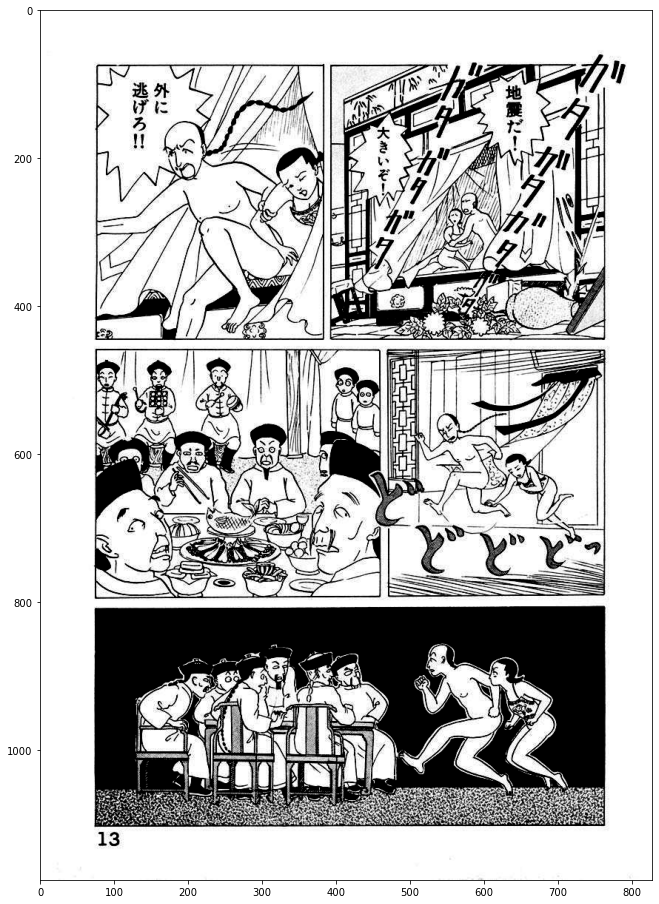

In [ ]:
plt.figure(figsize=(16, 16))
plt.imshow(x, cmap='gray')

In [ ]:
from torchvision import utils

resnet34 = torchvision.models.resnet34(weights='ResNet34_Weights.DEFAULT')

weight_tensor_1 = resnet34.conv1.weight.data # extract weights
print('Weights shape', weight_tensor_1.shape)

img_grid = utils.make_grid((weight_tensor_1 + 1) / 2, pad_value=1) # combine weights from all channel into table, note remapping to (0,1) range
print("Output is CxHxW image", img_grid.shape)

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12,12)
plt.imshow(np.transpose(img_grid, (1, 2, 0))) # change channel order for compability with numpy & matplotlib
plt.show()

In [ ]:
from torchvision import utils

weight_tensor_2 = model.cpu().resnet.conv1.weight.data # extract weights
print('Weights shape', weight_tensor_2.shape)

img_grid = utils.make_grid((weight_tensor_2 + 1) / 2, pad_value=1) # combine weights from all channel into table, note remapping to (0,1) range
print("Output is CxHxW image", img_grid.shape)

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12,12)
plt.imshow(np.transpose(img_grid, (1, 2, 0))) # change channel order for compability with numpy & matplotlib
plt.show()

In [ ]:
(abs(weight_tensor_1 - weight_tensor_2)).mean()

In [ ]:
weight_tensor_2